In [1]:
!pip install -q comet-ml
!pip install -q lightning
!pip install -q torchinfo
!pip install -q einops
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.6/710.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.3/980.3 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [2]:
# JEŻELI KOMÓRKA W KTÓREJ JEST TRENOWANIE ZOSTANIE PRZERWANA LUB SIĘ SKOŃCZY TO TRZEBA URUCHOMIĆ TĘ KOMÓRKĘ PONOWNIE!!!
# inaczej poprzedni eksperyment nie zakończy się i nowy trening będzie logowany w przerwanym eksperymencie

from lightning.pytorch.loggers import CometLogger
from google.colab import userdata

secret_value_0 = userdata.get('COMET_API_KEY')

comet_logger = CometLogger(
    api_key=secret_value_0,
    project_name=f'clustering',
    workspace='wikiart-inpainting',
)

#project_name=f'feature_extraction',
#project_name=f'clustering',


INFO: CometLogger will be initialized in online mode
INFO:lightning.pytorch.loggers.comet:CometLogger will be initialized in online mode


In [3]:
#Biblioteki do przetwarzania danych i modeli
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics.classification import MulticlassAccuracy
import h5py
from einops import rearrange
import pandas as pd
import numpy as np
from torchvision.transforms import v2
import torchvision.utils as vutils
from PIL import Image

#Biblioteki do klasteryzacji
from sklearn.cluster import KMeans

#Biblioteki do redukcji wymiarowości
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Biblioteki do wizualizacji
import matplotlib.pyplot as plt

#Biblioteki pomocnicze
from tqdm import tqdm


# Importy
import os
import sys



In [4]:
# Podłączenie Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ścieżka do zapisu modeli
save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)



Mounted at /content/drive


In [5]:
#Pakiety
'''Należy podać ścieżkę do lokalizacji pakietów!'''

sys.path.append('/content/drive/My Drive/FeatureExtractor')
sys.path.append('/content/drive/My Drive/Clustering')

from FeatureExtractor import FeatureExtractor
from UNetLightning import UNetLightning
from Clusterizer import Clusterizer

In [6]:
#Wybór urządzenia GPU (CUDA), jeśli dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


## Dane

### Pobranie datasetu z Kaggle

In [7]:
from google.colab import files

uploaded_files = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list --user milche

No datasets found


In [9]:
!kaggle datasets download -d milche/wikiart-clean-without-split

Dataset URL: https://www.kaggle.com/datasets/milche/wikiart-clean-without-split
License(s): unknown
100% 11.4G/11.4G [10:51<00:00, 21.0MB/s]
100% 11.4G/11.4G [10:51<00:00, 18.9MB/s]


In [10]:
!mkdir wikiart-clean
!unzip -q wikiart-clean-without-split.zip -d wikiart-clean

In [11]:
for dirname, _, filenames in os.walk('/content/wikiart-clean'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/wikiart-clean/dataset.h5
/content/wikiart-clean/annotations.csv


### Klasa Datasetu WikiArt

In [12]:
class WikiArtDataset(Dataset):
    def __init__(self, h5_path: str, csv_path: str, set_type: str, label_col='style', transform=None):
        self.h5_path = h5_path
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['set_type'] == set_type]
        self.label_col = label_col
        self.transform = transform
        self.length = len(self.df)

        self.label_mapping = {label: idx for idx, label in enumerate(self.df[self.label_col].unique())}

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

    def __getitem__(self, idx):
        self._open_hdf5()

        row = self.df.iloc[idx]
        image_idx = row['h5_index']

        label = self.label_mapping[row[self.label_col]]

        image = self._hf['image'][image_idx]
        image = torch.from_numpy(image)       #.float()

        if self.transform:
            image = self.transform(image)

        return image, label, image_idx

In [13]:
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

h5_path = '/content/wikiart-clean/dataset.h5'
csv_path = '/content/wikiart-clean/annotations.csv'

train_dataset = WikiArtDataset(
    h5_path=h5_path,
    csv_path=csv_path,
    set_type='train',
    transform=transforms
)

valid_dataset = WikiArtDataset(
    h5_path=h5_path,
    csv_path=csv_path,
    set_type='val',
    transform=transforms
)

test_dataset = WikiArtDataset(
    h5_path=h5_path,
    csv_path=csv_path,
    set_type='test',
    transform=transforms
)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

## Ekstrakcja cech

### Inicjalizacja modelu Ekstraktora Cech

In [23]:
model = UNetLightning()

In [24]:
feature_extractor = FeatureExtractor(model, device, comet_logger, save_dir)

print(feature_extractor.summary())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
UNet                                     [1, 3, 224, 224]          [1, 3, 224, 224]          --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 16, 224, 224]         --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 16, 224, 224]         448                       [3, 3]
│    └─ReLU: 2-2                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └─BatchNorm2d: 2-3                  [1, 16, 224, 224]         [1, 16, 224, 224]         32                        --
│    └─Conv2d: 2-4                       [1, 16, 224, 224]         [1, 16, 224, 224]         2,320                     [3, 3]
│    └─ReLU: 2-5                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └

### Trenowanie modelu Ekstraktora Cech

In [ ]:
feature_extractor.train(train_dataloader, valid_dataloader)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/unet-extractor/f20f38b3e6ca4e08bb2608263ec73adb

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Weights saved and logged to CometML: best_weights_epoch_0_val_loss_19216.4668.pth


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 18360.021


Weights saved and logged to CometML: best_weights_epoch_0_val_loss_18360.0215.pth


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : moccasin_motel_562
COMET INFO:     url                   : https://www.comet.com/wikiart-inpainting/unet-extractor/f20f38b3e6ca4e08bb2608263ec73adb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss_epoch     : 18587.52734375
COMET INFO:     train_loss_step [12] : (16800.6015625, 21387.3984375)
COMET INFO:     val_loss_epoch       : 18360.021484375
COMET INFO:     val_loss_step [81]   : (16068.2734375, 20668.068359375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     notebook_url : https://colab.research.go

### Wczytanie najlepszego modelu Ekstraktora Cech

In [25]:
#feature_extractor.load_from_checkpoint()

best_model_path = '/content/drive/MyDrive/Models/best_model.pth'
feature_extractor.load_from_checkpoint(best_model_path)

/content/drive/My Drive/FeatureExtractor/FeatureExtractor.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=self.device)

Model załadowany z pliku .pth: /content/drive/MyDrive/Models/best_model.pth
Pomyślnie załadowano model. Trainer ustawiony na 1 epok.


In [ ]:
feature_extractor.evaluate()

UNetLightning(
  (model): UNet(
    (encoder1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder3): Sequent

### Testowanie modelu Ekstraktora Cech

In [26]:
feature_extractor.test(test_dataloader)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/clustering/d488a1970cf04ea7a26ba68899198b6b

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.01348971575498581    │
└───────────────────────────┴───────────────────────────┘

COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : hissing_stadium_6466
COMET INFO:     url                   : https://www.comet.com/wikiart-inpainting/clustering/d488a1970cf04ea7a26ba68899198b6b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss_epoch     : 0.01348971575498581
COMET INFO:     test_loss_step [81] : (0.011590921320021152, 0.015007458627223969)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1ytenNvhxTDfbaEyIdzl68JkA2kgQd1oX
COMET INFO:   Uploads:
C

[{'test_loss_epoch': 0.01348971575498581}]

### Ekstrakcja cech - testowanie PCA dla różnych wartości redukcji

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
n_components_list = list(range(5, 125, 1))

In [ ]:
features_path = feature_extractor.test_pca_components(train_dataloader, n_components_list)

Processing batches:   0%|          | 0/120 [00:00<?, ?it/s]COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/feature-extraction/d2fb4adbd0de4c19aee5ca13b604e16b

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
Processing batches: 100%|██████████| 120/120 [07:55<00:00,  3.96s/it]


### Ekstrakcja cech zbioru treningowego

**Ekstrakcja cech z zastosowaniem najlepszej wartości redukcji cech dla PCA**

**Normalizacja cech przy pomocy MinMaxScaler**

In [ ]:
best_n_components = 28
#pca_model_path = '/content/drive/MyDrive/Models/pca_model.joblib'
file_name = 'train'

In [ ]:
train_features_path = feature_extractor.multi_features_extract(train_dataloader, best_n_components, file_name)

Processing batches:   0%|          | 0/323 [00:00<?, ?it/s]

PCA zostanie dopasowane


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Model PCA zapisany w: /content/drive/MyDrive/Models/pca_model.joblib

 Explained variance (wartości bezwzględne): 
 [15550.029    6020.265    3942.063    2381.2437   1868.5211   1073.9961
   973.5596    855.1512    692.92535   512.19226   501.2897    445.302
   400.75095   356.98172   333.2862    266.98706   250.60538   232.2069
   220.31955   197.27808   172.37302   166.1995    155.08774   149.93387
   137.71613   120.90774   112.66402   108.70367]

 Explained variance ratio (procentowo): 
 [0.3814113  0.14766514 0.09669098 0.05840718 0.04583111 0.02634299
 0.02387948 0.02097516 0.01699608 0.01256306 0.01229564 0.01092237
 0.00982962 0.00875605 0.00817485 0.00654866 0.00614685 0.00569557
 0.005404   0.00483884 0.00422797 0.00407654 0.00380399 0.00367758
 0.0033779  0.00296563 0.00276342 0.00266629]


COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/feature-extraction/fe6076cb8b404314a1b4a7de3178d929

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
Processing batches: 100%|██████████| 323/323 [02:59<00:00,  1.80it/s]


Scaler zostanie dopasowany i zapisany.
Model scaler zapisany w: /content/drive/MyDrive/Models/scaler_model.joblib

 Cechy i indeksy zapisane w: /content/drive/MyDrive/Result/train_features_and_indices.npz


### Ekstrakcja cech zbioru walidacyjnego

**Załadowanie modelu PCA**

**Załadowanie modelu MinMaxScaler**

In [ ]:
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
best_n_components = 28
pca_model_path = '/content/drive/MyDrive/Models/pca_model.joblib'
scaler_model_path = '/content/drive/MyDrive/Models/scaler_model.joblib'
file_name = 'valid'

In [ ]:
valid_features_path = feature_extractor.multi_features_extract(valid_dataloader, best_n_components, file_name, pca_model_path, scaler_model_path)

Załadowano model PCA z: /content/drive/MyDrive/Models/pca_model.joblib
Załadowano model scaler z: /content/drive/MyDrive/Models/scaler_model.joblib


Processing batches:   0%|          | 0/41 [00:00<?, ?it/s]

PCA zostanie dopasowane

 Explained variance (wartości bezwzględne): 
 [15550.029    6020.265    3942.063    2381.2437   1868.5211   1073.9961
   973.5596    855.1512    692.92535   512.19226   501.2897    445.302
   400.75095   356.98172   333.2862    266.98706   250.60538   232.2069
   220.31955   197.27808   172.37302   166.1995    155.08774   149.93387
   137.71613   120.90774   112.66402   108.70367]

 Explained variance ratio (procentowo): 
 [0.3814113  0.14766514 0.09669098 0.05840718 0.04583111 0.02634299
 0.02387948 0.02097516 0.01699608 0.01256306 0.01229564 0.01092237
 0.00982962 0.00875605 0.00817485 0.00654866 0.00614685 0.00569557
 0.005404   0.00483884 0.00422797 0.00407654 0.00380399 0.00367758
 0.0033779  0.00296563 0.00276342 0.00266629]


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : silent_report_9502
COMET INFO:     url                   : https://www.comet.com/wikiart-inpainting/feature-extraction/fa576a6adf6a4a33b7ccf0ef6282bbad
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1315qGjieKnUl4VZpvknYeOHHBUJ1N-HY
COMET INFO:   Uploads:
COMET INFO:     filename    : 1
COMET INFO:     notebook    : 1
COMET INFO:     source_code : 1
COMET INFO: 
COM


 Cechy i indeksy zapisane w: /content/drive/MyDrive/Result/valid_features_and_indices.npz


### Ekstrakcja cech z pojedynczego obrazu

**Załadowanie modelu PCA**

**Załadowanie modelu MinMaxScaler**

In [ ]:
current_image_idx = np.random.randint(0, len(test_dataset))

image, _, _ = test_dataset[current_image_idx]
print(np.shape(image))

features = feature_extractor.single_features_extract(image)
print(np.shape(features))

NameError: name 'test_dataset' is not defined

## Klasteryzacja

### Inicjalizacja Klasteryzatora

In [15]:
clusterizer = Clusterizer(comet_logger)

In [16]:
train_features_path = '/content/drive/MyDrive/Result/train_features_and_indices.npz'
valid_features_path = '/content/drive/MyDrive/Result/valid_features_and_indices.npz'
clusterizer.load_features('train', train_features_path)
clusterizer.load_features('valid', valid_features_path)

### Szacowanie liczby klastrów metodą łokcia

In [ ]:
clusterizer.draw_ebolow_method(1, 50)

Testing number of clusters: 100%|██████████| 49/49 [01:12<00:00,  1.48s/it]
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/clustering/1c4876a559064f76a8cb78e83bf8be61

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


### Szacowanie liczby klastrów z użyciem Spectral Clustering (15% zbioru)

In [ ]:
clusterizer.draw_spectral_method(2, 21, 0.1)

Testing number of clusters: 100%|██████████| 19/19 [08:18<00:00, 26.26s/it]


### Szacowanie liczby klastrów metodą Calinski-Harabasz Index

In [ ]:
#Indeks Calinskiego-Harabasza (zwany także "Variance Ratio Criterion") oblicza
#stosunek sumy wewnętrznej wariancji do wariancji między klastrami
clusterizer.draw_calinski_harabasz_method(2, 50)

Testing number of clusters with Calinski-Harabasz: 100%|██████████| 48/48 [01:20<00:00,  1.68s/it]
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/clustering/c5a72a3197e74b1aa653d34560ef5c4b

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


### Szacowanie liczby klastrów Silhouette Score ()

In [ ]:
clusterizer.draw_silhouette_score(2, 50, 0.75)

Testing number of clusters with Silhouette Score: 100%|██████████| 48/48 [44:36<00:00, 55.76s/it]
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/clustering/87bb00e6c63842b1ab8f8b37debd4f77

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


### Wizualizacja klastrów z UMAP (pełny zbiór) i TSNE (5k próbek)

In [ ]:
n_clusters = 6 #Warte przetestowania: 2, 3, 4, 5, 6, 7 9, 12

In [ ]:
clusterizer.generate_and_log_cluster_plot(n_clusters)

Rozpoczynam klasteryzację...


Klasteryzacja: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Rozpoczynam redukcję wymiarów (t-SNE)...


t-SNE: 100%|██████████| 1/1 [02:43<00:00, 163.63s/it]


Rozpoczynam redukcję wymiarów (UMAP)...


UMAP:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
UMAP: 100%|██████████| 1/1 [02:23<00:00, 143.99s/it]
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Tworzę wykres t-SNE...
Loguję wykres t-SNE na Comet...


COMET INFO: Experiment is live on comet.com https://www.comet.com/wikiart-inpainting/clustering/e384dbc2ba914ed8a5409426a2d38631

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Tworzę wykres UMAP...
Loguję wykres UMAP na Comet...
Proces zakończony.


### Klasteryzacja zbioru treningowego

In [ ]:
train_clusters_path = clusterizer.clusterize('train', n_clusters)

cluster_counts = clusterizer.count_samples_per_cluster(train_clusters_path)

Model KMeans zapisany w: /content/drive/MyDrive/Models/kmeans_model.pkl
Klastry i indeksy zapisane w: /content/drive/MyDrive/train_clusters.npz


### Klasteryzacja zbioru walidacyjnego

In [ ]:
valid_clusters_path = clusterizer.clusterize('valid', n_clusters)

cluster_counts = clusterizer.count_samples_per_cluster(valid_clusters_path)

Załadowano model KMeans z: /content/drive/MyDrive/Models/kmeans_model.pkl
Klastry i indeksy zapisane w: /content/drive/MyDrive/valid_clusters.npz


### Porównanie obrazów z losowwego klastra dla zbioru treningowego i walidacyjnego

Wybrano klaster: 0


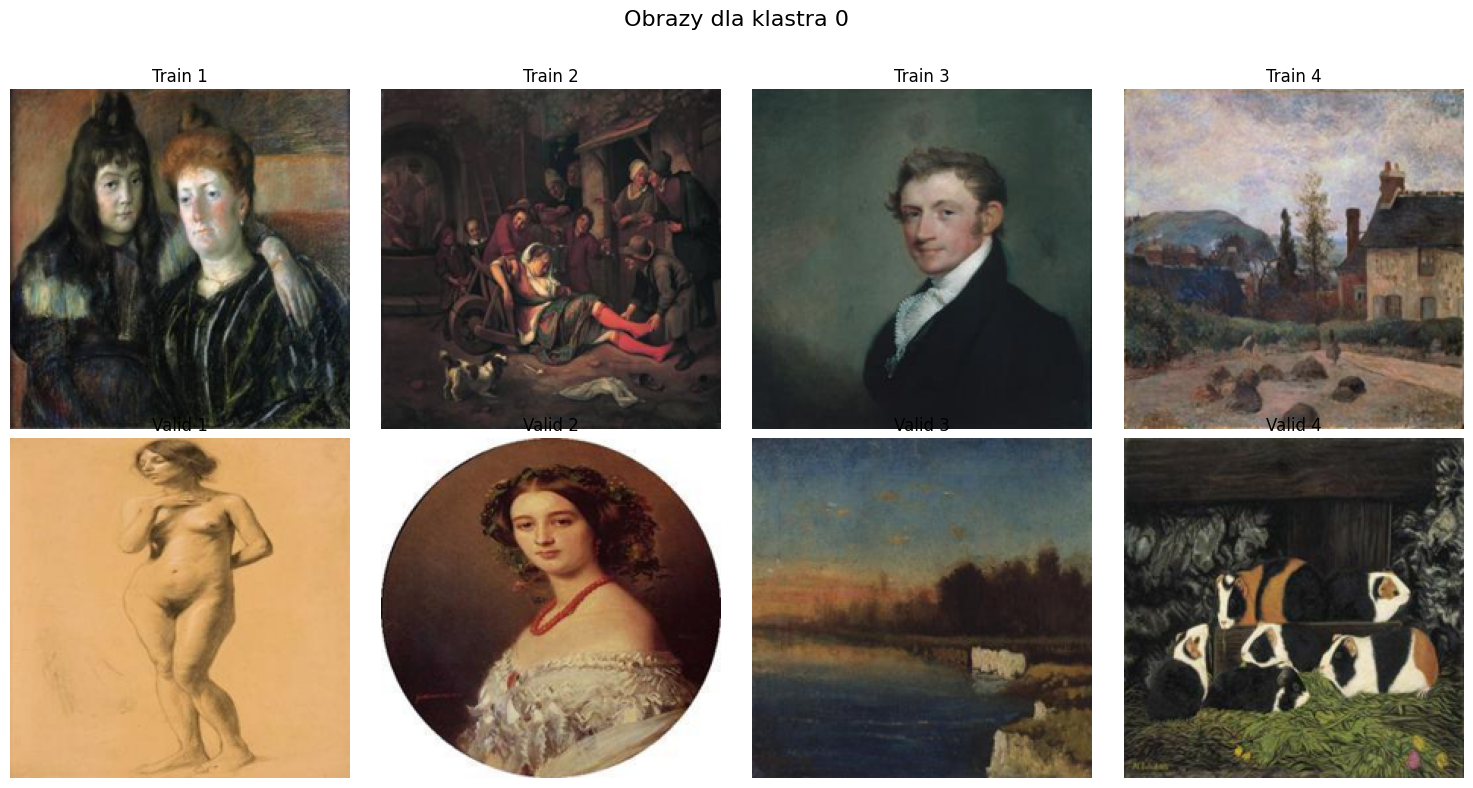

In [22]:
train_images, valid_images, cluster_id = clusterizer.get_images_from_random_cluster(
    train_cluster_file='/content/drive/MyDrive/train_clusters.npz',
    valid_cluster_file='/content/drive/MyDrive/valid_clusters.npz',
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

if train_images and valid_images:

    # Przygotowanie siatki dla obrazów
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(f"Obrazy dla klastra {cluster_id}", fontsize=16)

    # Funkcja pomocnicza do wyświetlania obrazów
    def show_images(images, row, title_prefix):
        for i, img in enumerate(images[:4]):  # Po 4 obrazy
            grid_np = img.permute(1, 2, 0).numpy()  # Przekształcenie do HxWxC
            axes[row, i].imshow(grid_np)
            axes[row, i].set_title(f"{title_prefix} {i+1}")
            axes[row, i].axis("off")

    # Wyświetlanie obrazów treningowych
    show_images(train_images, row=0, title_prefix="Train")

    # Wyświetlanie obrazów walidacyjnych
    show_images(valid_images, row=1, title_prefix="Valid")

    # Pokazanie wykresu
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Dostosowanie przestrzeni dla tytułu
    plt.show()
else:
    print("Nie można wyświetlić obrazów: brak danych w jednym z klastrów.")


## Pełne przetwarzanie dla pojedynczej próbki

In [ ]:
# Przed uruchomieniem poniższego kodu należy załadować wszystkie wymagane biblioteki
#i wykonać metody w sekcji "Dane"

In [ ]:
model = UNetLightning()

In [ ]:
feature_extractor = FeatureExtractor(model, device, comet_logger, save_dir)

print(feature_extractor.summary())

In [ ]:
best_model_path = '/content/drive/MyDrive/Models/best_model.pth'
feature_extractor.load_from_checkpoint(best_model_path)

In [ ]:
feature_extractor.evaluate()

In [ ]:
current_image_idx = np.random.randint(0, len(test_dataset))

image, _, _ = test_dataset[current_image_idx]
print(np.shape(image))

features = feature_extractor.single_features_extract(image)
print(np.shape(features))

In [ ]:
clusterizer = Clusterizer(comet_logger)

In [ ]:
n_clusters = 6

In [ ]:
cluster_label = clusterizer.clusterize('test', n_clusters, features)
print(cluster_label)